## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.ops import nms

from torchvision.transforms import transforms as T

from torch.utils.data import DataLoader, Dataset
from time import time
import datetime
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## Loading and Preprocessing Data

In [2]:
pwd

'/kaggle/working'

In [3]:
DATA_PATH = '../input/lisa-traffic-light-dataset'
os.listdir(DATA_PATH)

['nightTrain',
 'nightSequence1',
 'daySequence1',
 'Annotations',
 'sample-nightClip1',
 'sample-dayClip6',
 'daySequence2',
 'nightSequence2',
 'dayTrain']

In [4]:
DAY_TRAIN_PATH = '../input/lisa-traffic-light-dataset/Annotations/Annotations/dayTrain/'
NIGHT_TRAIN_PATH = '../input/lisa-traffic-light-dataset/Annotations/Annotations/nightTrain/'

In [5]:
os.listdir(DAY_TRAIN_PATH)

['dayClip13',
 'dayClip11',
 'dayClip7',
 'dayClip4',
 'dayClip1',
 'dayClip2',
 'dayClip12',
 'dayClip5',
 'dayClip8',
 'dayClip9',
 'dayClip6',
 'dayClip10',
 'dayClip3']

In [6]:
os.listdir(NIGHT_TRAIN_PATH)

['nightClip1', 'nightClip4', 'nightClip3', 'nightClip2', 'nightClip5']

In [7]:
train_day = []
for dayFileName in os.listdir(DAY_TRAIN_PATH):
    if 'dayClip' not in dayFileName:
        continue
    csvFile = os.path.join(DAY_TRAIN_PATH, dayFileName, 'frameAnnotationsBOX.csv')
    df = pd.read_csv(csvFile,sep=';')
    train_day.append(df)
train_day_df = pd.concat(train_day, axis=0)
train_day_df.head()

Filename Annotation tag  Upper left corner X  \
0  dayTraining/dayClip13--00000.jpg             go                  463   
1  dayTraining/dayClip13--00000.jpg             go                  616   
2  dayTraining/dayClip13--00000.jpg             go                  888   
3  dayTraining/dayClip13--00001.jpg             go                  461   
4  dayTraining/dayClip13--00001.jpg             go                  617   

   Upper left corner Y  Lower right corner X  Lower right corner Y  \
0                  177                   490                   222   
1                  185                   637                   235   
2                  300                   912                   345   
3                  176                   488                   216   
4                  197                   641                   227   

                                         Origin file  Origin frame number  \
0  dayTraining/dayClip13/dayClip13Shutter0.000200...                    0   
1  dayTraining/dayClip13/dayClip13Shutter0.000200...                    0   
2  dayTraining/dayClip13/dayClip13Shutter0.000200...                    0   
3  dayTraining/dayClip13/dayClip13Shutter0.000200...                    1   
4  dayTraining/dayClip13/dayClip13Shutter0.000200...                    1   

                                        Origin track  \
0  dayTraining/dayClip13/dayClip13Shutter0.000200...   
1  dayTraining/dayClip13/dayClip13Shutter0.000200...   
2  dayTraining/dayClip13/dayClip13Shutter0.000200...   
3  dayTraining/dayClip13/dayClip13Shutter0.000200...   
4  dayTraining/dayClip13/dayClip13Shutter0.000200...   

   Origin track frame number  
0                          0  
1                          0  
2                          0  
3                          1  
4                          1

In [8]:
train_night = []
for nightFileName in os.listdir(NIGHT_TRAIN_PATH):
    if 'nightClip' not in nightFileName:
        continue
    csvFile = os.path.join(NIGHT_TRAIN_PATH, nightFileName, 'frameAnnotationsBOX.csv')
    df = pd.read_csv(csvFile,sep=';')
    train_night.append(df)
train_night_df = pd.concat(train_night, axis=0)
train_night_df.head()

Filename Annotation tag  Upper left corner X  \
0  nightTraining/nightClip1--00000.jpg             go                  650   
1  nightTraining/nightClip1--00000.jpg             go                  709   
2  nightTraining/nightClip1--00000.jpg             go                  803   
3  nightTraining/nightClip1--00000.jpg             go                  687   
4  nightTraining/nightClip1--00000.jpg             go                  708   

   Upper left corner Y  Lower right corner X  Lower right corner Y  \
0                  280                   669                   319   
1                  286                   730                   322   
2                  332                   822                   371   
3                  347                   699                   371   
4                  347                   720                   371   

                          Origin file  Origin frame number  \
0  nightTraining/nightClip1/clip1.mp4                    0   
1  nightTraining/nightClip1/clip1.mp4                    0   
2  nightTraining/nightClip1/clip1.mp4                    0   
3  nightTraining/nightClip1/clip1.mp4                    0   
4  nightTraining/nightClip1/clip1.mp4                    0   

                         Origin track  Origin track frame number  
0  nightTraining/nightClip1/clip1.mp4                          0  
1  nightTraining/nightClip1/clip1.mp4                          0  
2  nightTraining/nightClip1/clip1.mp4                          0  
3  nightTraining/nightClip1/clip1.mp4                          0  
4  nightTraining/nightClip1/clip1.mp4                          0

In [9]:
df = pd.concat([train_day_df, train_night_df], axis=0)
df.head()

Filename Annotation tag  Upper left corner X  \
0  dayTraining/dayClip13--00000.jpg             go                  463   
1  dayTraining/dayClip13--00000.jpg             go                  616   
2  dayTraining/dayClip13--00000.jpg             go                  888   
3  dayTraining/dayClip13--00001.jpg             go                  461   
4  dayTraining/dayClip13--00001.jpg             go                  617   

   Upper left corner Y  Lower right corner X  Lower right corner Y  \
0                  177                   490                   222   
1                  185                   637                   235   
2                  300                   912                   345   
3                  176                   488                   216   
4                  197                   641                   227   

                                         Origin file  Origin frame number  \
0  dayTraining/dayClip13/dayClip13Shutter0.000200...                    0   
1  dayTraining/dayClip13/dayClip13Shutter0.000200...                    0   
2  dayTraining/dayClip13/dayClip13Shutter0.000200...                    0   
3  dayTraining/dayClip13/dayClip13Shutter0.000200...                    1   
4  dayTraining/dayClip13/dayClip13Shutter0.000200...                    1   

                                        Origin track  \
0  dayTraining/dayClip13/dayClip13Shutter0.000200...   
1  dayTraining/dayClip13/dayClip13Shutter0.000200...   
2  dayTraining/dayClip13/dayClip13Shutter0.000200...   
3  dayTraining/dayClip13/dayClip13Shutter0.000200...   
4  dayTraining/dayClip13/dayClip13Shutter0.000200...   

   Origin track frame number  
0                          0  
1                          0  
2                          0  
3                          1  
4                          1

In [10]:
df = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)
df.head()

Filename Annotation tag  Upper left corner X  \
0  dayTraining/dayClip13--00000.jpg             go                  463   
1  dayTraining/dayClip13--00000.jpg             go                  616   
2  dayTraining/dayClip13--00000.jpg             go                  888   
3  dayTraining/dayClip13--00001.jpg             go                  461   
4  dayTraining/dayClip13--00001.jpg             go                  617   

   Upper left corner Y  Lower right corner X  Lower right corner Y  \
0                  177                   490                   222   
1                  185                   637                   235   
2                  300                   912                   345   
3                  176                   488                   216   
4                  197                   641                   227   

   Origin frame number  
0                    0  
1                    0  
2                    0  
3                    1  
4                    1

In [11]:
df['Annotation tag'].unique()

array(['go', 'warning', 'stop', 'goLeft', 'warningLeft', 'stopLeft'],
      dtype=object)

In [12]:
df['Filename'].values[0]

'dayTraining/dayClip13--00000.jpg'

In [13]:
# Example: dayTraining/dayClip9--00000.jpg
def changeFilename(file):

    # Splits into [ dayTraining, dayClip9-00000]
    fileSplit = file.Filename.split('/')

    # Splits dayClip9-00000 into [ dayClip9, 00000] and grabs dayClip9
    clipNumber = fileSplit[-1].split('--')[0]
    
    # Create the full path for day files
    if 'day' in file.Filename:
        return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipNumber}/frames/{fileSplit[-1]}')

    # Creates the full path for night files
    if 'night' in file.Filename:
        return os.path.join(DATA_PATH,f'nightTrain/nightTrain/{clipNumber}/frames/{fileSplit[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [14]:
df['Filename'].values[0]

'../input/lisa-traffic-light-dataset/dayTrain/dayTrain/dayClip13/frames/dayClip13--00000.jpg'

In [15]:
# Removing the pictures that are too similar to each other 
print(df.shape)
df = df.iloc[::5]
print(df.shape)

(51826, 7)
(10366, 7)


In [16]:
df.rename(columns = {'Annotation tag': 'annotation_tag', 'Upper left corner X': 'top_left_X', 'Upper left corner Y': 'top_left_Y',
                                        'Lower right corner X': 'bot_right_X', 'Lower right corner Y': 'bot_right_Y',
                                        'Origin frame number': 'origin_frame_number'},
                                        inplace = True)

In [17]:
df = df.sort_values(by=['Filename'])
df.head()

Filename annotation_tag  \
4   ../input/lisa-traffic-light-dataset/dayTrain/d...             go   
9   ../input/lisa-traffic-light-dataset/dayTrain/d...             go   
14  ../input/lisa-traffic-light-dataset/dayTrain/d...             go   
19  ../input/lisa-traffic-light-dataset/dayTrain/d...             go   
24  ../input/lisa-traffic-light-dataset/dayTrain/d...             go   

    top_left_X  top_left_Y  bot_right_X  bot_right_Y  origin_frame_number  
4          698         331          710          356                    2  
9          852         383          864          408                    4  
14         699         330          711          350                    7  
19         860         388          872          408                    9  
24         699         328          714          353                   12

In [18]:
label_to_number = {'go':1, 'goLeft':2, 'warning':3, 'warningLeft':4, 'stop':5, 'stopLeft':6}

def label_to_number_function(x):
    
    if 'goLeft' in x['annotation_tag']:
        return label_to_number['goLeft']
    elif 'warningLeft' in x['annotation_tag']:
        return label_to_number['warningLeft']
    elif 'stopLeft' in x['annotation_tag']:
        return label_to_number['stopLeft']

    elif 'go' in x['annotation_tag']:
        return label_to_number['go']
    elif 'stop' in x['annotation_tag']:
        return label_to_number['stop']
    elif 'warning' in x['annotation_tag']:
        return label_to_number['warning']

In [19]:
df['annotation_tag'] = df.apply(label_to_number_function, axis=1)
annotation_tags = df['annotation_tag'].unique()
annotation_tags

array([1, 5, 6, 3, 2, 4])

## Choosing a Model

In [20]:
# https://pytorch.org/vision/stable/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#fasterrcnn-resnet50-fpn
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

# Replacing the classifier with one that uses my custom dataset

# classes = go, go left, warning, warning left, stop, stop left, background
num_classes = 7

# number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

## Defining the Traffic Light Dataset

In [21]:
class TrafficLightsDataset:
    def __init__(self, df, transforms=None):
        self.image_ids = df.Filename.unique()
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return self.image_ids.shape[0]
    
    def __getitem__(self, idx): 
        image_id = self.image_ids[idx]
        df = self.df[self.df.Filename == image_id]

        # Reading Image 
        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # Outline Boxes
        boxes = df[['top_left_X','top_left_Y','bot_right_X','bot_right_Y']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Object Labels
        labels = torch.as_tensor(df.annotation_tag.values)

        # Calculate the area of the boxes
        area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # iscrowd (UInt8Tensor[N]): instances with iscrowd=True will be ignored during evaluation.
        iscrowd = torch.torch.zeros_like(labels)

        targets = {}
        targets['boxes'] = boxes
        targets['labels'] = labels
        targets['Filename'] = torch.tensor([idx])
        targets['area'] = area
        targets['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': targets['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            targets['boxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)
            targets['labels'] = torch.as_tensor(sample['labels'])

        return image, targets, image_id


## Splitting the Dataset into Train - Test

In [22]:
df['clipNumber'] = df[['Filename']].applymap(lambda x: x.split('/')[5])
df['clipNumber'].unique()

array(['dayClip1', 'dayClip10', 'dayClip11', 'dayClip12', 'dayClip13',
       'dayClip2', 'dayClip3', 'dayClip4', 'dayClip5', 'dayClip6',
       'dayClip7', 'dayClip8', 'dayClip9', 'nightClip1', 'nightClip2',
       'nightClip3', 'nightClip4', 'nightClip5'], dtype=object)

In [23]:
def split(df):

    split = 0.8

    clipNames = sorted(df['clipNumber'].unique())
    dayClips = []
    nightClips = []

    for name in clipNames:
        if 'day' in name:
            dayClips.append(name)
            
    for name in clipNames:
        if 'night' in name:
            nightClips.append(name)

    trainDayClips = list(np.random.choice(dayClips, int(len(dayClips)*split)))
    trainNightClips = list(np.random.choice(nightClips, int(len(nightClips)*split)))
    trainClips = trainDayClips + trainNightClips

    testDayClips = list(set(dayClips) - set(trainDayClips))
    testNightClips = list(set(nightClips) - set(trainNightClips))
    testClips = testDayClips + testNightClips
    
    train = df[df.clipNumber.isin(trainClips)]
    test = df[df.clipNumber.isin(testClips)]

    return train, test

In [24]:
train, test = split(df)
print(train.shape)
print(test.shape)

(7134, 8)
(3232, 8)


## Transform Function for Data Augmentation

In [25]:
# Altering the original data to train the model with more accuracy 
def get_transform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        A.Flip(0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
        # pascal_voc format: [x_min, y_min, x_max, y_max]
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        A.Resize(height=512, width=512, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [26]:
dataset = TrafficLightsDataset(train, get_transform())
dataset_test = TrafficLightsDataset(test, get_test_transform())

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2,
                         collate_fn=collate_fn)

data_loader_test = DataLoader(dataset_test, batch_size=16, shuffle=True, num_workers=2,
                              collate_fn=collate_fn)

In [27]:
images, targets, image_ids = next(iter(data_loader))


In [28]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
image = images[0].permute(1,2,0).cpu().numpy()

In [29]:
targets[0]

{'boxes': tensor([[ 38.0000, 333.3333,  48.8000, 354.6667]]),
 'labels': tensor([5]),
 'Filename': tensor([655]),
 'area': tensor([1080.]),
 'iscrowd': tensor([0])}

In [30]:
def displayImage(image, boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 1)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

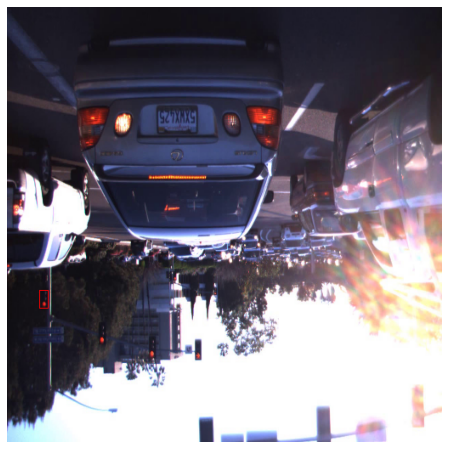

In [31]:
displayImage(image,boxes)

In [32]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [33]:
device

device(type='cuda')

In [34]:
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# construct a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [35]:
# Average loss -> (Total-Loss / Total-Iterations)
class LossAverager:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [36]:
EPOCHS = 3

lossHist = LossAverager()

for epoch in range(EPOCHS):
    
    start_time = time()
    model.train()
    lossHist.reset()
    
    for images, targets, image_ids in tqdm(data_loader):
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        bs = images.shape[0]
        
        loss_dict = model(images, targets)
        
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        
        lossHist.update(lossValue, bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()

    print(f"[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}]")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train loss: {lossHist.avg}")
    
    torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

100%|██████████| 439/439 [13:46<00:00,  1.88s/it]


[13:46]
Epoch 1/3
Train loss: 0.15382126414021016


100%|██████████| 439/439 [13:38<00:00,  1.86s/it]


[13:38]
Epoch 2/3
Train loss: 0.09771101967698835


100%|██████████| 439/439 [13:38<00:00,  1.87s/it]


[13:38]
Epoch 3/3
Train loss: 0.08618496850566461


In [37]:
model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn.pth'))

<All keys matched successfully>

In [38]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Testing the Model

In [39]:
images, targets, image_ids = next(iter(data_loader_test))
images = torch.stack(images).to(device)

outputs = model(images)

In [40]:
def filterBoxes(output,nms_th=0.3,score_threshold=0.5):
    
    boxes = output['boxes']
    scores = output['scores']
    labels = output['labels']
    
    # Non Max Supression
    mask = nms(boxes,scores,nms_th)
    
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    boxes = boxes.data.cpu().numpy().astype(np.int32)
    scores = scores.data.cpu().numpy()
    labels = labels.data.cpu().numpy()
    
    mask = scores >= score_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    return boxes, scores, labels

In [41]:
def displayPredictions(image_id,output,nms_th=0.3,score_threshold=0.5):
    
    boxes,scores,labels = filterBoxes(output,nms_th,score_threshold)
    
    # Preprocessing
    image = cv2.imread(image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = cv2.resize(image,(512,512))
    image /= 255.0
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    # Green - 0, 255, 0 - Go
    # Blue - 0, 0, 255 - Go Left
    # Yellow - 255, 255, 0 - Warning
    # Orange - 255, 128, 0 - Warning Left
    # Red - 255, 0, 0 - Stop
    # White - 255, 255, 255 - Stop Left

    colors = {1:(0,255,0), 2:(0,0,255), 3:(255,255,0),
              4:(255,128,0), 5:(255,0,0), 6:(255, 255, 255)}
    
    for box,label in zip(boxes,labels):
        image = cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      colors[label], 2)
        #print(colors[label])
        print(box[0], box[1], box[2], box[3])

    ax.set_axis_off()
    ax.imshow(image)
    
    plt.show()

411 91 422 118


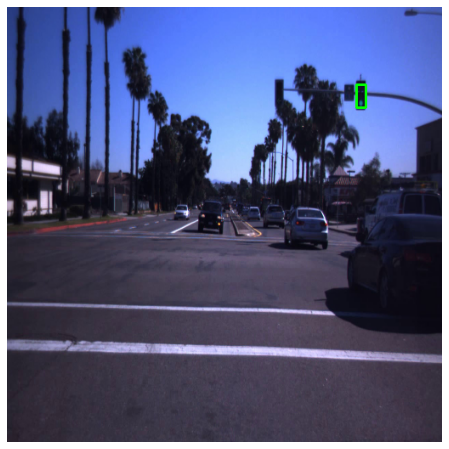

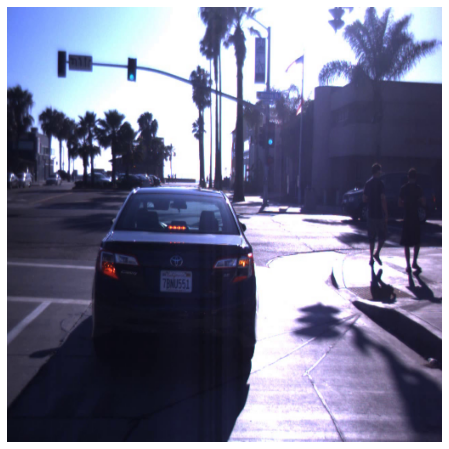

286 88 303 122
441 124 453 151
264 203 269 213
361 94 374 127


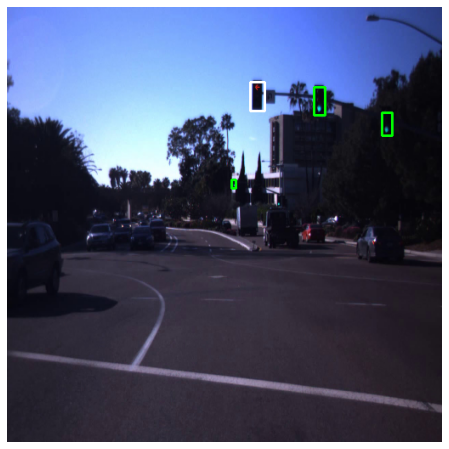

264 205 269 214
285 90 303 124
440 120 453 154
361 98 373 129


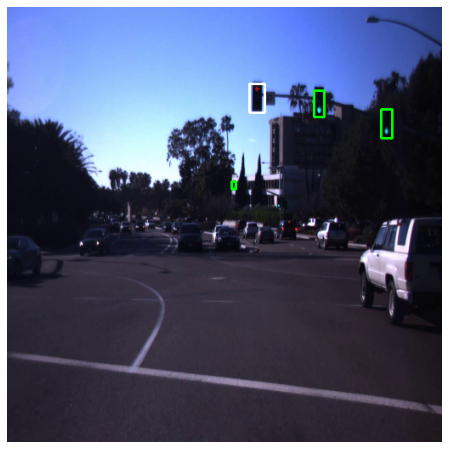

410 88 422 118
314 87 326 111


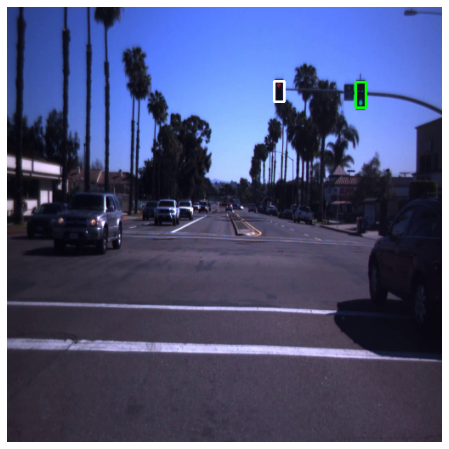

441 123 453 153
361 97 374 128
287 91 302 123


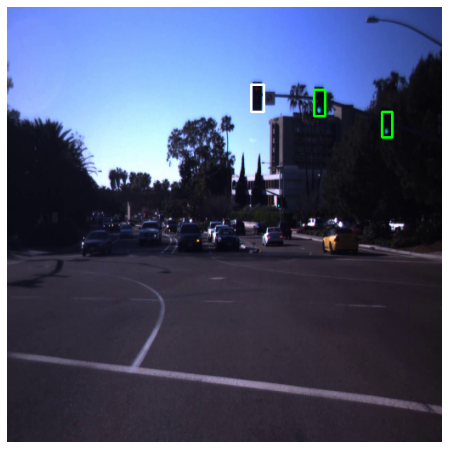

264 205 268 214
441 124 453 153
285 89 304 125
361 97 373 128


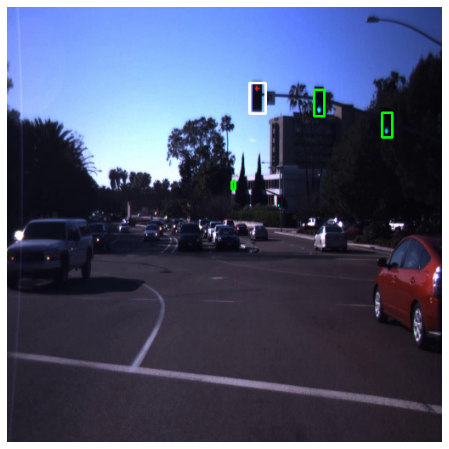

410 88 422 115
314 87 326 109


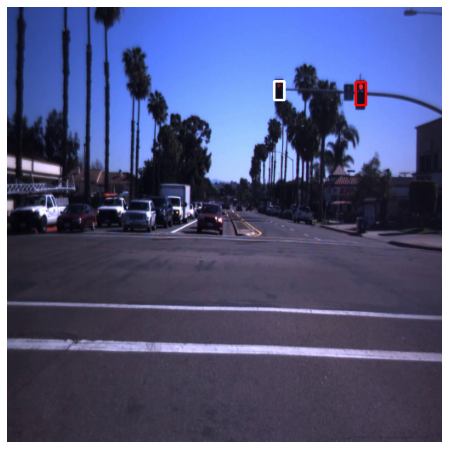

227 48 241 86
306 55 320 92
430 150 441 179


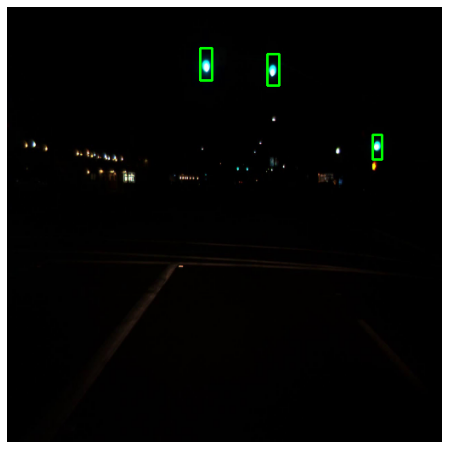

243 22 267 68
386 113 403 163


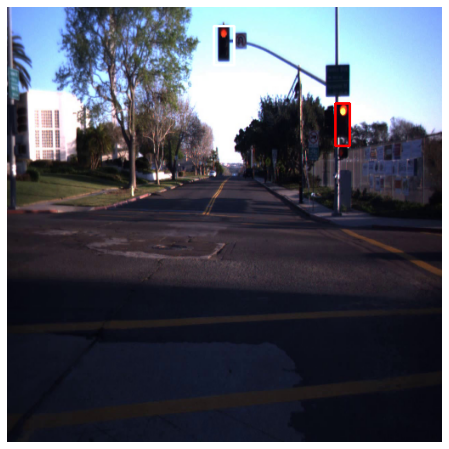

410 90 422 117


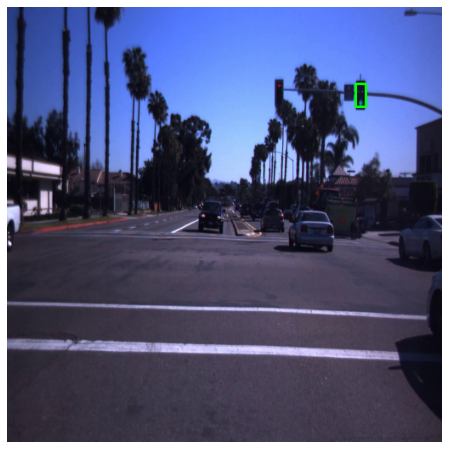

264 203 269 212
441 121 453 151
286 88 302 122
361 95 373 127


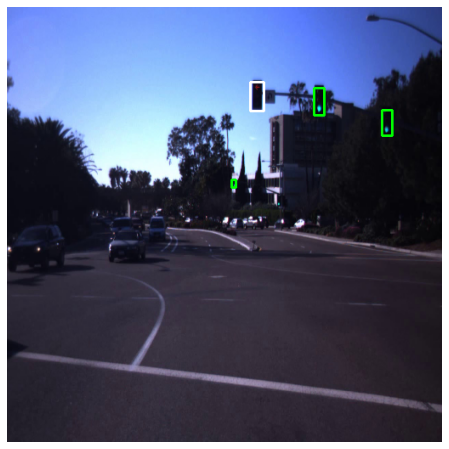

441 122 453 153
285 90 303 125
361 97 374 129


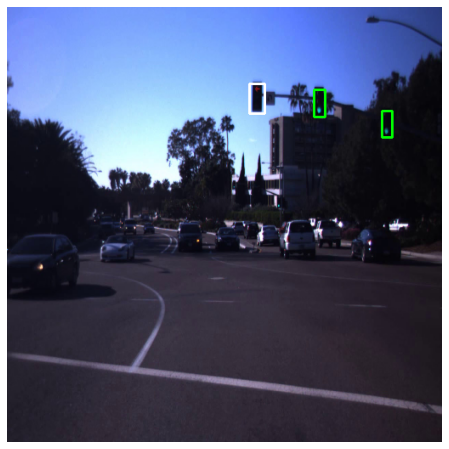

264 203 269 213
285 88 303 122
440 119 453 152
361 95 374 127


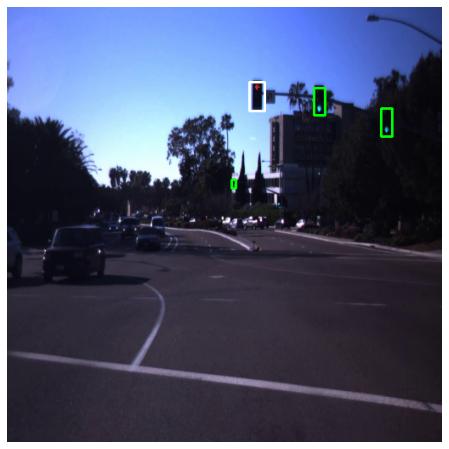

285 88 303 122
440 118 453 150
361 94 374 120


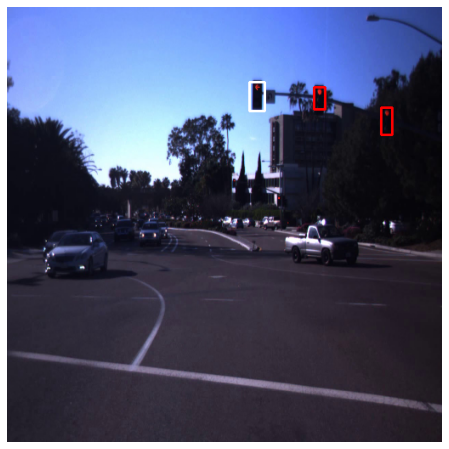

184 48 208 94
269 67 285 101


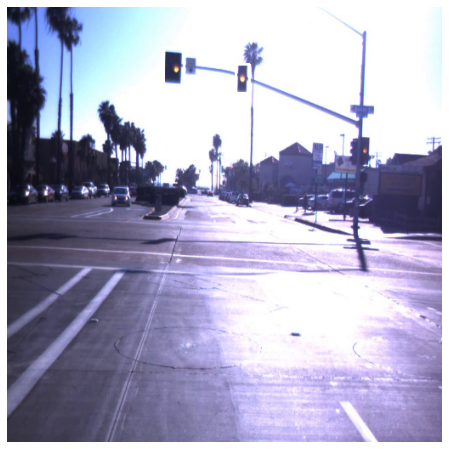

In [42]:
for i in range(len(image_ids)):
    displayPredictions(image_ids[i], outputs[i],0.2,0.4)